# Step 4 - Error Analysis
In this notebook, we perform both a quantitative and qualitative Analysis of some Step 3 Models errors

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, log_loss, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


Load Data and Predictions

In [18]:
# Load saved numpy arrays
lex_best_oof = np.load('../artifacts/lex_best_oof.npy')
emb_best_oof = np.load('../artifacts/emb_best_oof.npy')
y = np.load('../artifacts/y_true.npy')

# Load X_lex
X_lex = pd.read_csv('../artifacts/X_lex_train.csv')

# Load train_df
TRAIN_PATH = "../data/train.csv"
train_df = pd.read_csv(TRAIN_PATH).dropna()

# Recreate text fields
import ast

def extract_text_from_field(text_field):
    try:
        parsed = ast.literal_eval(text_field)
        if isinstance(parsed, list):
            return ' '.join(map(str, parsed))
        return str(parsed)
    except Exception:
        return str(text_field)

train_df['prompt_text'] = train_df['prompt'].apply(extract_text_from_field)
train_df['response_a_text'] = train_df['response_a'].apply(extract_text_from_field)
train_df['response_b_text'] = train_df['response_b'].apply(extract_text_from_field)

print("✅ Successfully loaded all files from Step 3")

# Ensemble parameters (hardcoded from your Step 3 output)
w = 0.45  # weight for lexical
T = 0.688  # temperature

✅ Successfully loaded all files from Step 3


PREPARE DATA FOR ANALYSIS


In [9]:
# Get predictions from each model
lex_preds = np.argmax(lex_best_oof, axis=1)
emb_preds = np.argmax(emb_best_oof, axis=1)

# For ensemble, recreate OOF predictions
ensemble_oof = w * lex_best_oof + (1 - w) * emb_best_oof

# Apply temperature scaling to ensemble OOF
def apply_temperature(p, T):
    z = np.log(np.clip(p, 1e-8, 1.0)).astype(float)
    z = z - z.mean(axis=1, keepdims=True)
    q = np.exp(z/T)
    q /= q.sum(axis=1, keepdims=True)
    return q

ensemble_oof_scaled = apply_temperature(ensemble_oof, T)
ensemble_preds = np.argmax(ensemble_oof_scaled, axis=1)

# True labels
y_true = y
class_names = ['Model A Wins', 'Model B Wins', 'Tie']

QUANTITATIVE ANALYSIS - OVERALL METRICS

In [29]:
print("\n" + "-"*80)
print("OVERALL PERFORMANCE METRICS")
print("-"*80)

models = {
    'Lexical (Isotonic)': (lex_best_oof, lex_preds),
    'Embeddings (Isotonic)': (emb_best_oof, emb_preds),
    'Ensemble (Weighted + Temp)': (ensemble_oof_scaled, ensemble_preds)
}

results = []
for name, (probs, preds) in models.items():
    ll = log_loss(y_true, probs, labels=[0, 1, 2])
    acc = np.mean(preds == y_true)
    results.append({
        'Model': name,
        'Log Loss': ll,
        'Accuracy': acc
    })
    print(f"\n{name}:")
    print(f"  Log Loss: {ll:.5f}")
    print(f"  Accuracy: {acc:.4f} ({acc*100:.2f}%)")

results_df = pd.DataFrame(results)
print("\n" + "-"*80)
print("PERFORMANCE COMPARISON TABLE:")
print(results_df.to_string(index=False))


--------------------------------------------------------------------------------
OVERALL PERFORMANCE METRICS
--------------------------------------------------------------------------------

Lexical (Isotonic):
  Log Loss: 1.06124
  Accuracy: 0.4454 (44.54%)

Embeddings (Isotonic):
  Log Loss: 1.06670
  Accuracy: 0.4264 (42.64%)

Ensemble (Weighted + Temp):
  Log Loss: 1.04875
  Accuracy: 0.4556 (45.56%)

--------------------------------------------------------------------------------
PERFORMANCE COMPARISON TABLE:
                     Model  Log Loss  Accuracy
        Lexical (Isotonic)  1.061235  0.445430
     Embeddings (Isotonic)  1.066703  0.426362
Ensemble (Weighted + Temp)  1.048753  0.455591


PER-CLASS LOG LOSS

In [30]:
print("\n" + "-"*80)
print("PER-CLASS LOG LOSS ANALYSIS")
print("-"*80)

def per_class_log_loss(y_true, y_probs):
    """Calculate log loss for each class separately"""
    per_class_losses = []
    for c in [0, 1, 2]:
        mask = (y_true == c)
        if mask.sum() > 0:
            # Log loss for samples of this class
            true_probs = y_probs[mask, c]
            ll = -np.mean(np.log(np.clip(true_probs, 1e-8, 1.0)))
            per_class_losses.append(ll)
        else:
            per_class_losses.append(np.nan)
    return per_class_losses

for name, (probs, preds) in models.items():
    losses = per_class_log_loss(y_true, probs)
    print(f"\n{name}:")
    for i, (cls_name, loss) in enumerate(zip(class_names, losses)):
        count = np.sum(y_true == i)
        print(f"  {cls_name:20s}: {loss:.5f} (n={count})")


--------------------------------------------------------------------------------
PER-CLASS LOG LOSS ANALYSIS
--------------------------------------------------------------------------------

Lexical (Isotonic):
  Model A Wins        : 1.00939 (n=20064)
  Model B Wins        : 1.02652 (n=19652)
  Tie                 : 1.15821 (n=17761)

Embeddings (Isotonic):
  Model A Wins        : 1.01828 (n=20064)
  Model B Wins        : 1.03836 (n=19652)
  Tie                 : 1.15277 (n=17761)

Ensemble (Weighted + Temp):
  Model A Wins        : 0.97525 (n=20064)
  Model B Wins        : 1.00174 (n=19652)
  Tie                 : 1.18381 (n=17761)


Confusion Matrix Analysis


--------------------------------------------------------------------------------
CONFUSION MATRICES
--------------------------------------------------------------------------------

Lexical (Isotonic) - Raw Counts:
[[11625  6289  2150]
 [ 6633 10870  2149]
 [ 7729  6925  3107]]

Lexical (Isotonic) - Normalized (by row):
[[0.57939593 0.31344697 0.1071571 ]
 [0.3375229  0.55312436 0.10935274]
 [0.43516694 0.38989922 0.17493384]]

Embeddings (Isotonic) - Raw Counts:
[[11018  6070  2976]
 [ 7475  9174  3003]
 [ 7483  5964  4314]]

Embeddings (Isotonic) - Normalized (by row):
[[0.54914274 0.3025319  0.14832536]
 [0.38036841 0.46682272 0.15280887]
 [0.42131637 0.3357919  0.24289173]]

Ensemble (Weighted + Temp) - Raw Counts:
[[12121  6051  1892]
 [ 6847 10887  1918]
 [ 7864  6719  3178]]

Ensemble (Weighted + Temp) - Normalized (by row):
[[0.60411683 0.30158493 0.09429825]
 [0.34841238 0.55398942 0.09759821]
 [0.44276786 0.37830077 0.17893137]]


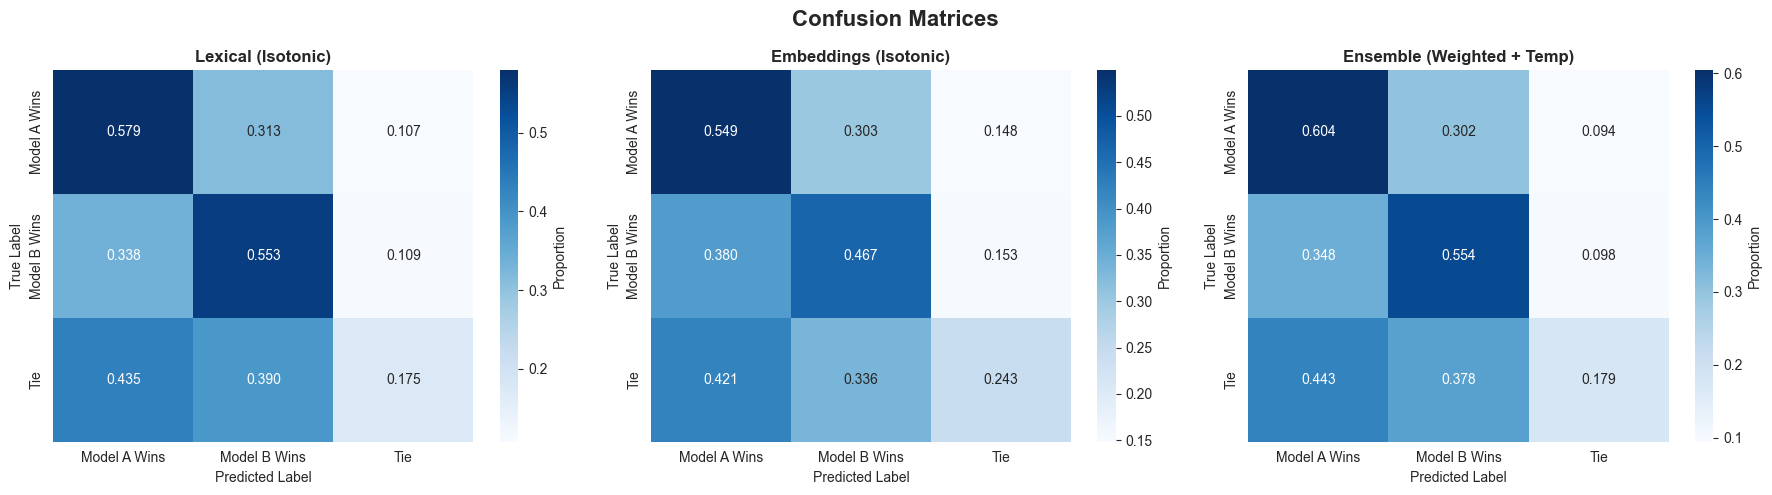

In [31]:
print("\n" + "-"*80)
print("CONFUSION MATRICES")
print("-"*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

for idx, (name, (probs, preds)) in enumerate(models.items()):
    cm = confusion_matrix(y_true, preds, labels=[0, 1, 2])
    
    # Normalize by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[idx], cbar_kws={'label': 'Proportion'})
    axes[idx].set_title(name, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    
    # Print raw counts
    print(f"\n{name} - Raw Counts:")
    print(cm)
    print(f"\n{name} - Normalized (by row):")
    print(cm_normalized)

plt.tight_layout()
plt.show()

Qualitative Error Analysis

Examining specific examples of misclassifications to understand model weaknesses.

In [32]:
print("\n" + "-"*80)
print("QUALITATIVE EXAMPLES")
print("-"*80)

# Find interesting cases
ensemble_correct = (ensemble_preds == y_true)
lex_correct = (lex_preds == y_true)
emb_correct = (emb_preds == y_true)

# Case 1: Ensemble correct, both components wrong
case1 = ensemble_correct & ~lex_correct & ~emb_correct
print(f"\nCase 1: Ensemble correct, both components wrong: {case1.sum()} cases")

# Case 2: Both components correct, ensemble wrong
case2 = ~ensemble_correct & lex_correct & emb_correct
print(f"Case 2: Both components correct, ensemble wrong: {case2.sum()} cases")

# Case 3:All models wrong
case3 = ~ensemble_correct & ~lex_correct & ~emb_correct
print(f"Case 3: All models wrong: {case3.sum()} cases")

# Function to display examples
def show_examples(mask, title, n=1):
    print(f"\n{title}")
    print("="*80)
    
    indices = np.where(mask)[0]
    if len(indices) == 0:
        print("No examples found.")
        return
    
    # Sample random examples
    sample_indices = np.random.choice(indices, size=min(n, len(indices)), replace=False)
    
    for i, idx in enumerate(sample_indices, 1):
        print(f"\n--- Example {i} (Index: {idx}) ---")
        print(f"True: {class_names[y_true[idx]]}")
        print(f"Lexical: {class_names[lex_preds[idx]]} ({lex_best_oof[idx][lex_preds[idx]]:.3f})")
        print(f"Embeddings: {class_names[emb_preds[idx]]} ({emb_best_oof[idx][emb_preds[idx]]:.3f})")
        print(f"Ensemble: {class_names[ensemble_preds[idx]]} ({ensemble_oof_scaled[idx][ensemble_preds[idx]]:.3f})")
        
        print(f"\nPrompt: {train_df.iloc[idx]['prompt_text'][:100]}...")
        print(f"Response A: {train_df.iloc[idx]['response_a_text'][:100]}...")
        print(f"Response B: {train_df.iloc[idx]['response_b_text'][:100]}...")

# Show fewer examples for each case
import random
random.seed(42)
np.random.seed(42)
show_examples(case1, "CASE 1: Ensemble Correct, Components Wrong", n=1)
show_examples(case2, "CASE 2: Components Correct, Ensemble Wrong", n=1)
show_examples(case3, "CASE 3: All Models Wrong", n=1)


--------------------------------------------------------------------------------
QUALITATIVE EXAMPLES
--------------------------------------------------------------------------------

Case 1: Ensemble correct, both components wrong: 252 cases
Case 2: Both components correct, ensemble wrong: 0 cases
Case 3: All models wrong: 22360 cases

CASE 1: Ensemble Correct, Components Wrong

--- Example 1 (Index: 37770) ---
True: Model B Wins
Lexical: Tie (0.359)
Embeddings: Model A Wins (0.355)
Ensemble: Model B Wins (0.346)

Prompt: why cant you trust atoms? Because they make up everything. it was a joke...
Response A: As an AI language model, I don't have personal opinions or beliefs. However, I can provide you with ...
Response B: While atoms are the fundamental building blocks of matter and everything in the universe is made up ...

CASE 2: Components Correct, Ensemble Wrong
No examples found.

CASE 3: All Models Wrong

--- Example 1 (Index: 38128) ---
True: Tie
Lexical: Model B Wins (0.352)

CONFIDENCE ANALYSIS

In [33]:
print("\n" + "-"*80)
print("CONFIDENCE ANALYSIS")
print("-"*80)

# Maximum probability as confidence
lex_confidence = np.max(lex_best_oof, axis=1)
emb_confidence = np.max(emb_best_oof, axis=1)
ensemble_confidence = np.max(ensemble_oof_scaled, axis=1)

# Bin by confidence
confidence_bins = [0, 0.4, 0.6, 0.8, 1.0]
confidence_labels = ['Low (0-0.4)', 'Medium (0.4-0.6)', 'High (0.6-0.8)', 'Very High (0.8-1.0)']

for name, (probs, preds, conf) in [
    ('Lexical', (lex_best_oof, lex_preds, lex_confidence)),
    ('Embeddings', (emb_best_oof, emb_preds, emb_confidence)),
    ('Ensemble', (ensemble_oof_scaled, ensemble_preds, ensemble_confidence))
]:
    print(f"\n{name}:")
    
    conf_cat = pd.cut(conf, bins=confidence_bins, labels=confidence_labels)
    correct = (preds == y_true).astype(int)
    
    conf_analysis = pd.DataFrame({
        'Confidence': conf_cat,
        'Correct': correct
    }).groupby('Confidence').agg(['mean', 'count'])
    
    conf_analysis.columns = ['Accuracy', 'Count']
    print(conf_analysis)


--------------------------------------------------------------------------------
CONFIDENCE ANALYSIS
--------------------------------------------------------------------------------

Lexical:
                     Accuracy  Count
Confidence                          
Low (0-0.4)          0.380732  25120
Medium (0.4-0.6)     0.493542  31896
High (0.6-0.8)       0.644737    456
Very High (0.8-1.0)  0.400000      5

Embeddings:
                     Accuracy  Count
Confidence                          
Low (0-0.4)          0.372372  31302
Medium (0.4-0.6)     0.484132  25491
High (0.6-0.8)       0.744152    684
Very High (0.8-1.0)       NaN      0

Ensemble:
                     Accuracy  Count
Confidence                          
Low (0-0.4)          0.372762  21220
Medium (0.4-0.6)     0.486924  33383
High (0.6-0.8)       0.703588   2871
Very High (0.8-1.0)  0.333333      3


BIAS ANALYSIS

In [34]:
# Position bias: Does the model prefer A or B?
print("\nPrediction Distribution:")
print("-"*80)

for name, (probs, preds) in models.items():
    pred_dist = pd.Series(preds).value_counts(normalize=True).sort_index()
    true_dist = pd.Series(y_true).value_counts(normalize=True).sort_index()
    
    print(f"\n{name}:")
    for i in [0, 1, 2]:
        pred_pct = pred_dist.get(i, 0) * 100
        true_pct = true_dist.get(i, 0) * 100
        print(f"  {class_names[i]:20s}: {pred_pct:5.2f}% (true: {true_pct:5.2f}%)")

# Verbosity bias: Correlation between length and prediction
print("\n\nVerbosity Bias Analysis:")
print("-"*80)

for name, (probs, preds) in models.items():
    print(f"\n{name}:")
    
    # When A is longer
    a_longer = X_lex['len_diff'] > 0
    pred_a_when_a_longer = np.mean(preds[a_longer] == 0) if a_longer.sum() > 0 else 0
    
    # When B is longer
    b_longer = X_lex['len_diff'] < 0
    pred_b_when_b_longer = np.mean(preds[b_longer] == 1) if b_longer.sum() > 0 else 0
    
    print(f"  Predicts A wins when A is longer: {pred_a_when_a_longer*100:.2f}%")
    print(f"  Predicts B wins when B is longer: {pred_b_when_b_longer*100:.2f}%")



Prediction Distribution:
--------------------------------------------------------------------------------

Lexical (Isotonic):
  Model A Wins        : 45.21% (true: 34.91%)
  Model B Wins        : 41.90% (true: 34.19%)
  Tie                 : 12.89% (true: 30.90%)

Embeddings (Isotonic):
  Model A Wins        : 45.19% (true: 34.91%)
  Model B Wins        : 36.90% (true: 34.19%)
  Tie                 : 17.91% (true: 30.90%)

Ensemble (Weighted + Temp):
  Model A Wins        : 46.68% (true: 34.91%)
  Model B Wins        : 41.16% (true: 34.19%)
  Tie                 : 12.16% (true: 30.90%)


Verbosity Bias Analysis:
--------------------------------------------------------------------------------

Lexical (Isotonic):
  Predicts A wins when A is longer: 85.19%
  Predicts B wins when B is longer: 79.62%

Embeddings (Isotonic):
  Predicts A wins when A is longer: 57.25%
  Predicts B wins when B is longer: 48.95%

Ensemble (Weighted + Temp):
  Predicts A wins when A is longer: 78.77%
  Predic